<a href="https://colab.research.google.com/github/iritwikdas/assignment_predict_now_ai/blob/main/Assignment_Predictnowai_Ritwik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metalabelling Assignment Predict Now
*By Ritwik Das*

Lets say we place a "Buy" order in a stock (AAPL) and hold it for 5 days. 

If the price is going down and trigger stoploss we exit at stop loss limit, if the price is going up, we take profit at certain level. In few cases, stock goes sideways, we exit on 5th day of holding.

Based on these rules, we would need levels to plan entry and exit. There would be **2 price levels (SL and Target)** and **2 time levels (Start day and Final day of holding)**.

So technically we are trying to create a window that would encapsulate price, whent the price hits the either of the 3 edge (barrier) of window, we exit.

Enter image here

In [21]:
%%capture
pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import yfinance as yf

In [4]:
def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download('AAPL', start = begin_date,
                     auto_adjust=True,#only download adjusted data
                     end= end_date) 
    #my convention: always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df
Apple_stock = get_data('AAPL', '1999-12-31', '2010-12-30')   
price = Apple_stock['close']

[*********************100%***********************]  1 of 1 completed


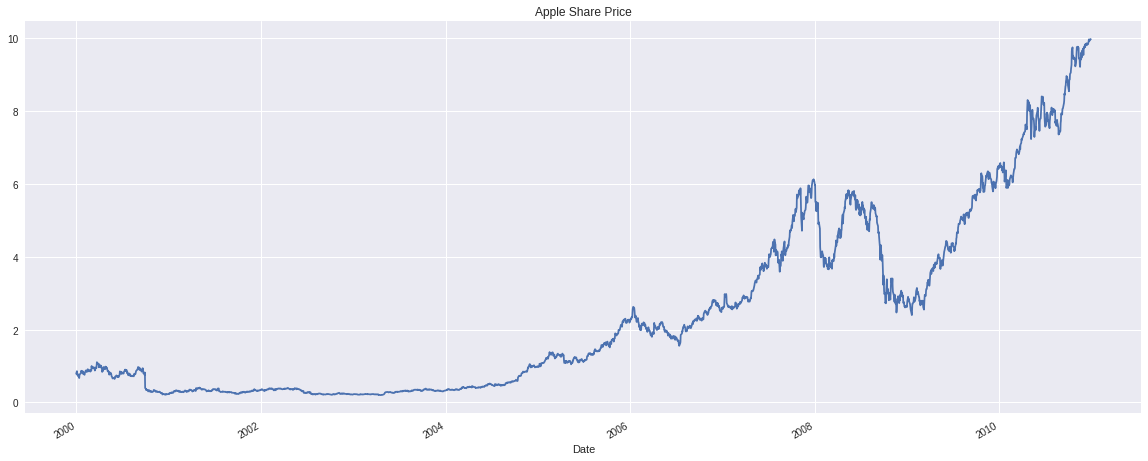

In [22]:
price.plot(figsize=(20, 8), title='Apple Share Price')

# **Daily Volatility**


With daily data, we can use a simple percentage returns’ Exponential weighted moving average (EWM) as the volatility.

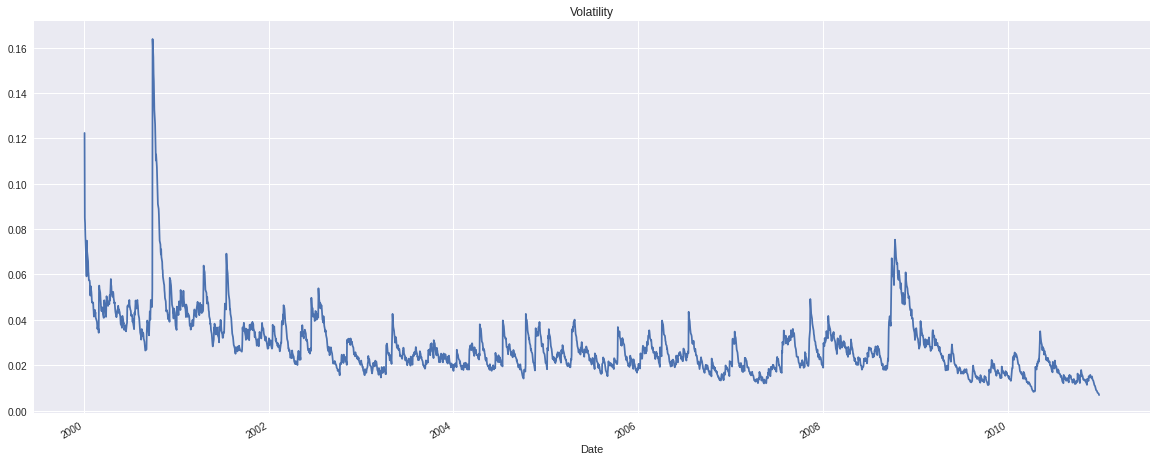

In [6]:
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)
df0.plot(figsize=(20, 8), title='Volatility')
plt.show()

# Triple-Barrier


As we discussed we would require 3 levels to create a window, we would be utilizing tripple barrier method to do this.

1.  The **horizontal barriers** can be thought of as ***profit-taking or stop-loss limits***. 

>> *Rather than fixing a preconcieved notion of threshold profit, we will be using a dynamic function that calculates a rolling threshold value based on daily volatility. This would allow us to set more optimal thresholds based on recent performance.*


2.  The **vertical barrier** acts as the the expiration limit defined by number of bars elapsed (as opposed to time). This ensures that sampling ranges are roughly equivalent in terms of market activity as opposed to an arbitrary time period.


To summarize, we have three possible scenarios with two possible outcomes:

1.  The upper barrier (profit-take) is hit first. Label = “buy” or “1”.
2.  The lower barrier (stop-loss) is hit first. Label = “sell” or “-1”.
3.  The vertical barrier (expiration) is hit first. Label = “buy” or “sell” based on the return achieved at expiration.


Before begining with the algorithm, we need to set the parameters as below:


*   **Data**: Apple 10-years stock price
*   **Hold** for: 5 days
*   **Profit-taking boundary**: 2 times of 20 days return EWM std
*   **Stop-loss boundary**: 2 times of 20 days return EWM std




In [7]:
#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 5 
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]
#allign the index
prices = price[daily_volatility.index]

# **Triple Barrier Algorithm**

In [8]:
def get_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vert_barrier', 'top_barrier', 'bottom_barrier'],index = daily_volatility.index)
    
    for day,vol in daily_volatility.iteritems(): 

      days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])

        #set the vertical barrier 
      if(days_passed + t_final < len(daily_volatility.index) and t_final != 0):
        
        vert_barrier = daily_volatility.index[days_passed + t_final]
      
      else:
            vert_barrier = np.nan

        #set the top barrier

      if upper_lower_multipliers[0] > 0:

            top_barrier = prices.loc[day] + prices.loc[day] * upper_lower_multipliers[0] * vol

      else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)

        #set the bottom barrier

      if upper_lower_multipliers[1] > 0:

            bottom_barrier = prices.loc[day] - prices.loc[day] * upper_lower_multipliers[1] * vol

      else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)

      barriers.loc[day, ['days_passed', 'price','vert_barrier','top_barrier', 'bottom_barrier']] = days_passed, prices.loc[day], vert_barrier, top_barrier, bottom_barrier
            
    return barriers

In [9]:
barriers = get_barriers()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier
Date,,,,,
2000-01-04,1,0.785788,2000-01-12 00:00:00,0.978108,0.593467
2000-01-05,2,0.797286,2000-01-13 00:00:00,0.932697,0.661876
2000-01-06,3,0.72829,2000-01-14 00:00:00,0.848572,0.608009
2000-01-07,4,0.762789,2000-01-18 00:00:00,0.88059,0.644987
2000-01-10,5,0.749373,2000-01-19 00:00:00,0.850476,0.64827
...,...,...,...,...,...
2010-12-22,2760,9.97099,NaN,10.1304,9.81157
2010-12-23,2761,9.92315,NaN,10.0795,9.76683
2010-12-27,2762,9.95627,NaN,10.1059,9.80661


Example visualisation of a particular triple barrier instance

<Figure size 144x144 with 0 Axes>

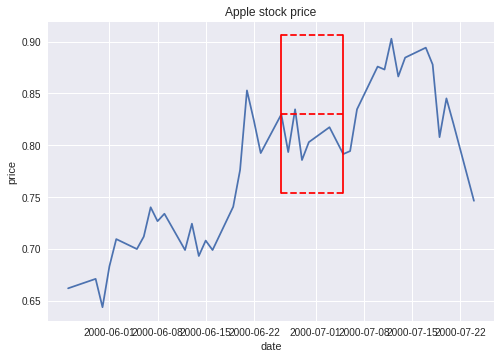

<Figure size 144x144 with 0 Axes>

In [35]:
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100: 140])
start = barriers.index[120]
end = barriers.vert_barrier[120]
upper_barrier = barriers.top_barrier[120]
lower_barrier = barriers.bottom_barrier[120]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');
plt.figure(figsize=(2, 2))

In [10]:
barriers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2000-01-04 to 2010-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   days_passed     2764 non-null   object
 1   price           2764 non-null   object
 2   vert_barrier    2758 non-null   object
 3   top_barrier     2764 non-null   object
 4   bottom_barrier  2764 non-null   object
dtypes: object(5)
memory usage: 209.6+ KB


In [11]:
barriers['labels'] = None
barriers.head()

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,labels
Date,,,,,,
2000-01-04,1,0.785788,2000-01-12 00:00:00,0.978108,0.593467,None
2000-01-05,2,0.797286,2000-01-13 00:00:00,0.932697,0.661876,None
2000-01-06,3,0.72829,2000-01-14 00:00:00,0.848572,0.608009,None
2000-01-07,4,0.762789,2000-01-18 00:00:00,0.88059,0.644987,None
2000-01-10,5,0.749373,2000-01-19 00:00:00,0.850476,0.64827,None


Before defining get_labels function, I would like to define some variables.



* **start** : First day of window
* **end** : Last day of  window
* **price_initial** : stock price in first day
* **price_final** : stock price in last day
* **top_barrier** : level of profit taking 
* **bottom_barrier** : level of stop loss 
* **condition_pt** : top_barrier / profit taking level touching conditon
* **condition_sl** : bottom_barrier / stop loss level touching conditon




In [12]:
def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assigning the initial price and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assigning the top barrier and bottom barrier
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #setting profit taking (upper barrier touch) and stop loss (lower barrier touch) conditons
            condition_pt = (barriers.price[start: end] >= top_barrier).any()
            condition_sl = (barriers.price[start: end] <= bottom_barrier).any()
            #assigning the labels
            if condition_pt: 
                barriers['labels'][i] = 1
            elif condition_sl: 
                barriers['labels'][i] = -1    
            else: 
                barriers['labels'][i] = max(
                          [(price_final - price_initial)/(top_barrier - price_initial),(price_final - price_initial)/ (price_initial - bottom_barrier)],key=abs)
    return

get_labels()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,labels
Date,,,,,,
2000-01-04,1,0.785788,2000-01-12 00:00:00,0.978108,0.593467,-0.610381
2000-01-05,2,0.797286,2000-01-13 00:00:00,0.932697,0.661876,-0.410455
2000-01-06,3,0.72829,2000-01-14 00:00:00,0.848572,0.608009,0.346561
2000-01-07,4,0.762789,2000-01-18 00:00:00,0.88059,0.644987,0.288778
2000-01-10,5,0.749373,2000-01-19 00:00:00,0.850476,0.64827,0.668215
...,...,...,...,...,...,...
2010-12-22,2760,9.97099,NaN,10.1304,9.81157,None
2010-12-23,2761,9.92315,NaN,10.0795,9.76683,None
2010-12-27,2762,9.95627,NaN,10.1059,9.80661,None


To get an estimate of how the labels are distributed, I have used a box plot to visualise the same.

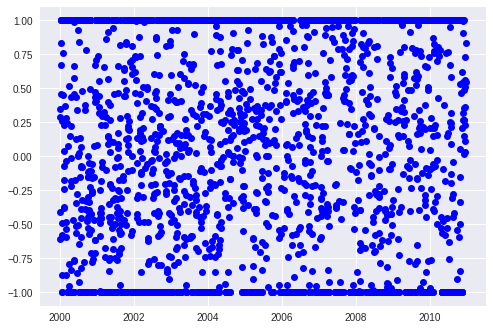

In [24]:
plt.plot(barriers.labels,'bo')

The same distribution can be visualised in a more intuitive way using scatterplot. Here Green-Red gradient is used to denote profit taking and loss taking labels.

Note: Here the x axis is days passed.

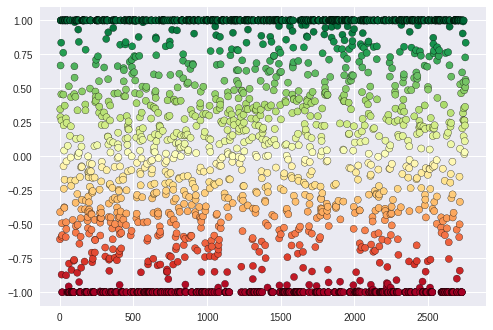

In [14]:
plt.scatter(barriers.days_passed, barriers.labels, c = barriers.labels, cmap = "RdYlGn", s=50, edgecolors="black")

In [15]:
barriers.labels.value_counts()

 1.000000    952
-1.000000    620
 0.000000      6
 0.743665      1
-0.150020      1
            ... 
-0.108434      1
 0.675538      1
-0.338813      1
-0.767804      1
-0.957190      1
Name: labels, Length: 1183, dtype: int64

In [16]:
barriers['metalabels'] = None
barriers.head()

for i in range(len(barriers.index)):
  if (barriers['labels'][i]) == 1:
   barriers['metalabels'][i]= 1
  elif (barriers['labels'][i]) == -1:
   barriers['metalabels'][i]= -1
  else: barriers['metalabels'][i] = 0

barriers.to_csv('labels.csv')

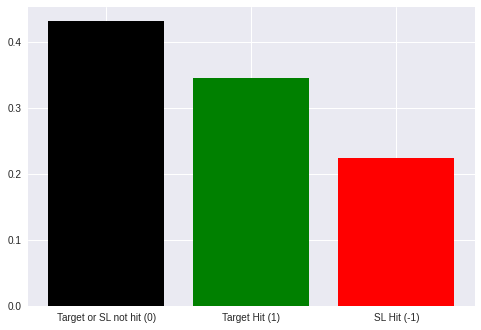

In [17]:
occ = barriers['metalabels'].value_counts(normalize = True)
a = pd.to_numeric(occ[0])
b = pd.to_numeric(occ[1])
c = pd.to_numeric(occ[-1])
values = [a,b,c]
bars = ['Target or SL not hit (0)', 'Target Hit (1)', 'SL Hit (-1)']
x_pos = np.arange(len(bars))
plt.bar(x_pos, values, color=['black', 'green','red'])
plt.xticks(x_pos,bars)
plt.show()

Finally, a quick overview of the output .csv file that contains meta-labels (last column) along with other details.

In [38]:
import pandas as pd
data = pd.read_csv("labels.csv")
data.head(50)

,Date,days_passed,price,vert_barrier,top_barrier,bottom_barrier,labels,metalabels
0,2000-01-04,1,0.785788,2000-01-12 00:00:00,0.978108,0.593467,-0.610381,0
1,2000-01-05,2,0.797286,2000-01-13 00:00:00,0.932697,0.661876,-0.410455,0
2,2000-01-06,3,0.728290,2000-01-14 00:00:00,0.848572,0.608009,0.346561,0
3,2000-01-07,4,0.762789,2000-01-18 00:00:00,0.880590,0.644987,0.288778,0
4,2000-01-10,5,0.749373,2000-01-19 00:00:00,0.850476,0.648270,0.668215,0
5,2000-01-11,6,0.711042,2000-01-20 00:00:00,0.800164,0.621919,1.000000,1
6,2000-01-12,7,0.668399,2000-01-21 00:00:00,0.747510,0.589287,1.000000,1
7,2000-01-13,8,0.741706,2000-01-24 00:00:00,0.852842,0.630570,1.000000,1
8,2000-01-14,9,0.769975,2000-01-25 00:00:00,0.878282,0.661669,0.836119,0
9,2000-01-18,10,0.796807,2000-01-26 00:00:00,0.901702,0.691913,0.456783,0
